In [2]:
import btk
import cv2 as cv
import dataset_generators as dgen
import datetime
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import time
from PIL import Image, ImageDraw
from tensorflow import keras
from keras import layers

tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
plt.style.use(f"{os.environ['style']}")


In [ ]:
#Demo set
""" tx, ty = dgen.gen_tdet_data(1, dgen.evalfonts, dgen.chars, True)
for i, x in enumerate(tx):
    display(Image.fromarray(x))
    display(ty[i]) """

""" num = 90000
for i, x in enumerate(valx_1[num:num + 10]):
    display(Image.fromarray(x))
    display(valy_1[i]) """

In [2]:
trainx_1, trainy_1, valx_1, valy_1 = btk.depickler('trainx-1645175114', 'trainy-1645175114', 'valx-1645175114', 'valy-1645175114', 'ocr')
trainx_2, trainy_2, valx_2, valy_2 = btk.depickler('trainx-1645175477', 'trainy-1645175477', 'valx-1645175477', 'valy-1645175477', 'ocr')
trainx_3, trainy_3, valx_3, valy_3 = btk.depickler('trainx-1645175777', 'trainy-1645175777', 'valx-1645175777', 'valy-1645175777', 'ocr')


""" trainx, trainy = dgen.gen_tdet_data(21500, dgen.trainfonts, dgen.chars, True)
valx, valy = dgen.gen_tdet_data(7150, dgen.evalfonts, dgen.chars, False)
trainx = np.array([np.flip(x, random.randint(0, 1)) if random.randint(0, 3) == 0 else x for x in trainx])
valx = np.array([np.rot90(x, random.randint(1, 3)) if random.randint(0, 3) == 0 else x for x in valx])
btk.pickle_set(trainx, trainy, valx, valy, 'ocr') """

" trainx, trainy = dgen.gen_tdet_data(21500, dgen.trainfonts, dgen.chars, True)\nvalx, valy = dgen.gen_tdet_data(7150, dgen.evalfonts, dgen.chars, False)\ntrainx = np.array([np.flip(x, random.randint(0, 1)) if random.randint(0, 3) == 0 else x for x in trainx])\nvalx = np.array([np.rot90(x, random.randint(1, 3)) if random.randint(0, 3) == 0 else x for x in valx])\nbtk.pickle_set(trainx, trainy, valx, valy, 'ocr') "

In [ ]:
def model_init():
    inp = keras.Input(shape=(64, 64, 1))
    x = layers.Rescaling(1.0/255)(inp)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization(axis=3)(x)
    for features in [32, 64, 128]:
        res = x
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=3)(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.1)(x)
        res = layers.Conv2D(features, 1, strides=2, activation='relu')(res)
        x = layers.add([x, res])
        x = layers.BatchNormalization(axis=3)(x)
        res = x
        x = layers.Conv2D(features, 3, padding='same', activation='relu')(x)
        x = layers.add([x, res])
        x = layers.BatchNormalization(axis=3)(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.3678)(x)
    outp = layers.Dense(1, activation='sigmoid')(x)

    opti = keras.optimizers.Adam(learning_rate=0.001)
    mod = keras.Model(inp, outp, name='tseg')
    mod.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    return mod

tdet = model_init()
tdet.summary()

In [6]:
if not "tnum" in locals():
    tnum = 0
measure = 'accuracy'
imgent = btk.DataGen(trainx_1, trainy_1, 144)
imgenv = btk.DataGen(valx_1, valy_1, 48)
log_dir = f"tblogs/detection/0/{tnum}/"
tbcall = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tnum += 1
tdet = model_init()
tstart = time.time()
history = tdet.fit(
    x = imgent,
    validation_data=imgenv,
    epochs=64,
    steps_per_epoch=32,
    validation_steps=32,
    callbacks=[tbcall],
    verbose=0
)
tstop = time.time()
ttime = tstop - tstart
btk.mlstats(history.history, measure, ttime)

Score: 0.9471358890098566
Best VAccuracy: 0.9778645634651184
Best VLoss: 0.06509371846914291
Last 7 Avg VAccuracy: 0.9678199461528233
Last 7 Avg VLoss: 0.09919055444853646
Training time: 209.0477545261383
Samples per second: 2507.981973728618


In [ ]:
if not 'best_score' in locals():
    best_score = 0.9
metric = 'accuracy'
log_dir = "tblogs/detection/1/"

for i in range(7):
    if i in [0, 3, 6]:
        trainx_1 = np.array([np.flip(x, random.randint(0, 1)) for x in trainx_1])
        valx_1 = np.array([np.rot90(x, random.randint(1, 3)) for x in valx_1])
        tgen = btk.DataGen(trainx_1, trainy_1, 144)
        vgen = btk.DataGen(valx_1, valy_1, 48)
    elif i in [1, 4]:
        trainx_2 = np.array([np.flip(x, random.randint(0, 1)) for x in trainx_2])
        valx_2 = np.array([np.rot90(x, random.randint(1, 3)) for x in valx_2])
        tgen = btk.DataGen(trainx_2, trainy_2, 144)
        vgen = btk.DataGen(valx_2, valy_2, 48)
    elif i in [2, 5]:
        trainx_3 = np.array([np.flip(x, random.randint(0, 1)) for x in trainx_3])
        valx_3 = np.array([np.rot90(x, random.randint(1, 3)) for x in valx_3])
        tgen = btk.DataGen(trainx_3, trainy_3, 144)
        vgen = btk.DataGen(valx_3, valy_3, 48)
    tbcall = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    estop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=32, restore_best_weights=True)
    calls = [tbcall]
    if i == 6:
        calls = [estop, tbcall]
    history = tdet.fit(
        x = tgen,
        validation_data=vgen,
        epochs=64,
        steps_per_epoch=32,
        validation_steps=32,
        callbacks=calls,
        verbose=0
    )
    score = (max(history.history.get(f"val_{metric}")) + (2.7182818**-(min(history.history.get("val_loss"))))
            + (sum(history.history.get(f"val_{metric}")[-7:]) / 7) + (sum(2.7182818**-(np.array(history.history.get("val_loss")[-7:]))) / 7)
            ) / 4
    btk.mlstats(history.history, metric)
    if score > best_score:
        print(f'Model Updated        New Rating: {score}  |  Old Rating: {best_score}')
        tdet.save('models\\tdet-3')
        best_score = score


In [60]:
tdet = tf.keras.models.load_model('models\\tdet-2')
#tdet.save('models\\tdet-1')

In [277]:
def contour_bounds(img) -> list[tuple[np.ndarray, list]]:
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
    #display(htree)
    #display(conts)
    #imc = cv.drawContours(cv.cvtColor(img, cv.COLOR_GRAY2BGR), conts, -1, (0,255,0), 2)
    #display(Image.fromarray(imc))
    bounds = []
    for x in conts:
        xset = [y[0][0] for y in x]
        yset = [y[0][1] for y in x]
        bounds.append((min(yset), max(yset), min(xset), max(xset)))
        bounds = [x for x in bounds if (x[1] - x[0]) * (x[3] - x[2]) > 512 and x[1] - x[0] > 6]
    return bounds

def expand_coordinates(bounds: tuple[int, ...], idims: tuple[int, int], stretch: tuple[float, float] = (0.085, 0.085)) -> tuple[int, ...]:
    """Expands coordinate inputs slightly to account for imprecise text detection"""
    for i, x in enumerate(bounds):
        ygap = (x[1] - x[0]) * stretch[0]
        xgap = (x[3] - x[2]) * stretch[1]
        bounds[i] = [round(x[0] - (ygap * 1.5)), round(x[1] + (ygap * 0.5)), round(x[2] - xgap), round(x[3] + xgap)]
    for i, x in enumerate(bounds):
        if x[0] < 0:
            bounds[i][0] = 0
        if x[1] > idims[0]:
            bounds[i][1] = idims[0]
        if x[2] < 0:
            bounds[i][2] = 0
        if x[3] > idims[1]:
            bounds[i][3] = idims[1]
    return bounds

def sat_check(img):
    img = cv.Canny(img, 50, 200, apertureSize=3)
    img = cv.GaussianBlur(img, (9, 1), 9)
    img = cv.GaussianBlur(img, (1, 5), 5)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=4)
    img[img > 0] = 255
    if np.sum(img) / (img.size * 255) > 0.5:
        return True

def drawbox(img: Image, coords: list) -> Image:
    for x in coords:
        ImageDraw.Draw(img).rectangle((x[2], x[0], x[3], x[1]), outline=127, width=3)
    return img


def txt_detect(img: np.ndarray, sdims: tuple[int, int], sens: float, sfactor: float = True) -> tuple[int, ...]:
    """
    Use ML model to determine if text appears within an image

    Args:
        img (np.ndarray): Image to analyze
        sens (float): Sensitivity threshold for text detection 

    Returns:
        list[tuple[int, ...], np.ndarray]: Coordinates of regions that have text within the image
    """
    if sfactor:
        sfactor = img.size
    oshape = img.shape
    sc_coeff = (sfactor / img.size)**0.5
    img = btk.resize(img, (round(img.shape[0] * sc_coeff), round(img.shape[1] * sc_coeff)))
    img = btk.fit2dims(img, sdims)
    coord_scale = ((oshape[0] / img.shape[0], oshape[1] / img.shape[1]))
    slices = btk.img_slicer(img, sdims, sdims, 2)
    coords = btk.gen_index(img.shape, sdims, sdims, 2)
    predictions = tdet.predict(slices)
    tcords = []
    for i, x in enumerate(predictions):
        if x > sens:
            tcords.append((coords[i], x[0]))
    #display(drawbox(Image.fromarray(img), [x[0] for x in tcords]))
    for i, x in enumerate(tcords):
        tcords[i] = (np.array([x[0][0] * coord_scale[0],
                            x[0][1] * coord_scale[0],
                            x[0][2] * coord_scale[1],
                            x[0][3] * coord_scale[1]]).astype('uint16'), x[1])
    return tcords

def txt_heat_mapper(img: np.ndarray, sdims: tuple[int, int], sens: float) -> np.ndarray:
    """Generates a heatmap for text locations on an image"""
    img = btk.fit2dims(img, sdims)
    iarea = img.size
    score_card = np.zeros((img.shape[0], img.shape[1]), dtype='float16')
    """ if iarea < 1048576:
        cords = txt_detect(img, sdims, sens - ((1 - sens) - ((1 - sens) ** 1.666)), iarea * 4)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1]) """
    if iarea < 2097152:
        cords = txt_detect(img, sdims, sens - ((1 - sens) - ((1 - sens) ** 1.333)), iarea * 2)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    cords = txt_detect(img, sdims, sens, iarea)
    for x in cords:
        score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    if iarea > 2097152:
        cords = txt_detect(img, sdims, sens ** 0.666, iarea / 2)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1])
    """ if iarea > 4194304:
        cords = txt_detect(img, sdims, sens ** 0.333, iarea / 4)
        for x in cords:
            score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] = score_card[x[0][0]:x[0][1], x[0][2]:x[0][3]] + (np.ones((x[0][1] - x[0][0], x[0][3] - x[0][2])) * x[1]) """
    """ img = btk.fit2dims(img, (64, 64))
    combined = cv.addWeighted(img, 0.3, score_card.astype('uint8') * 50, 0.7, 1)
    display(Image.fromarray(combined)) """
    return score_card

def textract_images(img: np.ndarray, coords: tuple[int, ...]) -> list[np.ndarray]:
    """Extract image regions defineed by coordinate list input"""
    imarr = np.array(img)
    extracted = [imarr[x[0]:x[1], x[2]:x[3]] for x in coords]
    return extracted

def trimmer(iar):
    img = np.array(iar)
    hgram = np.histogram(img.flatten(), 255, (0, 255))
    pix_mode = hgram[0].argmax()
    if pix_mode > 127:
        img = np.invert(img)
        pix_mode = 255 - pix_mode
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 21, 29)
    img = np.invert(img)
    img = cv.medianBlur(img, 3)
    img[img < 127] = 0
    img[img > 0] = 255
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=-1)
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=1)
    img = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=1)
    img = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=-1)
    img = np.uint8(np.absolute(img))
    img = cv.medianBlur(img, 3)
    img = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=-1)
    img = np.uint8(np.absolute(img))
    img = cv.erode(img, np.ones((2, 2)), iterations=1)
    img = cv.GaussianBlur(img, (9, 1), 9, 1)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, np.ones((2, 2), np.uint8), iterations=2)
    img[img > 0] = 255
    img = cv.GaussianBlur(img, (7, 1), 7, 1)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, np.ones((2, 2), np.uint8), iterations=1)
    img[img > 0] = 255
    bounds = contour_bounds(img)
    bounds = expand_coordinates(bounds, iar.shape, (0.06, 0.03))
    for x in bounds.copy():
        if x[1] - x[0] + 6 > x[3] - x[2]:
            if x[3] - x[2] < 128:
                bounds.remove(x)
    for x in bounds.copy():
        for y in bounds.copy():
            if x[0] > y[0] and x[1] < y[1] and x[2] > y[2] and x[3] < y[3]:
                try:
                    bounds.remove(x)
                except: ValueError
    return [(iar[x[0]:x[1], x[2]:x[3]], x) for x in bounds]

def get_text(img: np.ndarray, sdims: tuple[int, int], sens: float) -> list[np.ndarray]:
    """
    Identify and extract image regions containing text

    Args:
        img (np.ndarray): Image
        sdims (tuple[int, int]): Dimensions of the image slices
        sens (float): Sensitivity of the detection model

    Returns:
        list[np.ndarray]: Image regions containing text in array form
    """
    iar = btk.grey_np(img)
    img = cv.adaptiveThreshold(iar, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 17, 15)
    img = np.invert(img)
    img = cv.medianBlur(img, 3)
    img[img < 127] = 0
    img[img > 0] = 255
    mtrx = txt_heat_mapper(img, sdims, sens)
    img = np.rot90(img, 2)
    mtrx += np.rot90(txt_heat_mapper(img, sdims, sens), 2)
    img = cv.adaptiveThreshold(iar, 254, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 17, 21)
    img = cv.medianBlur(img, 3)
    mtrx += txt_heat_mapper(img, sdims, sens)
    img = np.rot90(img, 2)
    mtrx += np.rot90(txt_heat_mapper(img, sdims, sens), 2)
    mtrx = np.array(mtrx, dtype='uint8')
    img = btk.fit2dims(iar, (64, 64))
    """ combined = cv.addWeighted(img, 0.3, mtrx * 15, 0.7, 1)
    display(Image.fromarray(combined)) """
    hgram = np.histogram(mtrx.flatten(), 9)
    mtrx[mtrx < hgram[1][hgram[0].argmin()] - 1] = 0
    mtrx[mtrx > 0] = 255
    mtrx = cv.GaussianBlur(mtrx, (67, 31), 49)
    mtrx[mtrx > 0] = 255
    boxes = contour_bounds(mtrx)
    for x in boxes.copy():
        for y in boxes.copy():
            if x[0] > y[0] and x[1] < y[1] and x[2] > y[2] and x[3] < y[3]:
                try:
                    boxes.remove(x)
                except: ValueError
    iar = btk.fit2dims(iar, (64, 64))
    boxes = [(iar[x[0]:x[1], x[2]:x[3]], x) for x in boxes]
    txt_areas = {}
    for x in boxes:
        for y in trimmer(x[0]):
            txt_areas.update({(y[1][0] + x[1][0], y[1][1] + x[1][0], y[1][2] + x[1][2], y[1][3] + x[1][2]): y[0]})
    return txt_areas



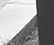

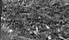

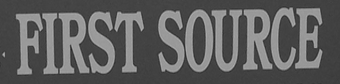

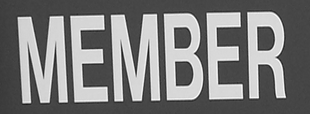

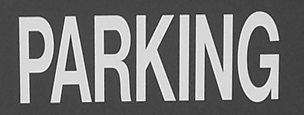

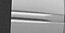

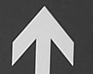

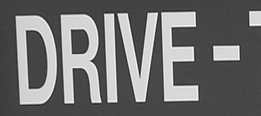

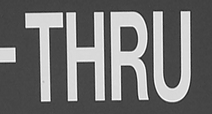

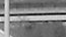

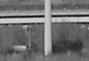

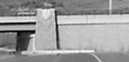

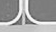

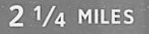

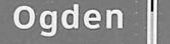

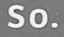

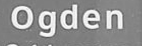

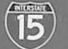

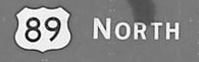

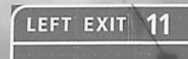

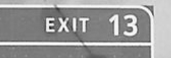

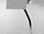

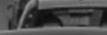

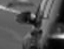

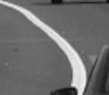

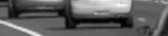

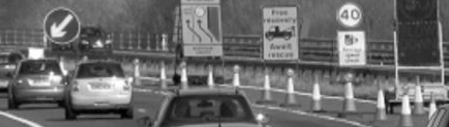

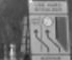

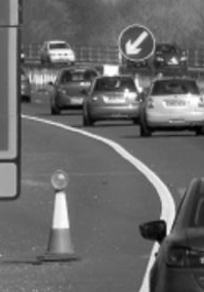

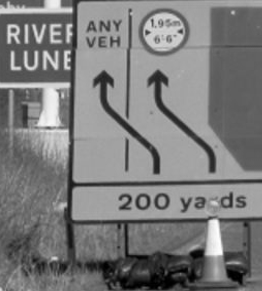

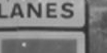

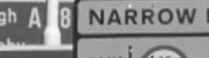

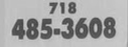

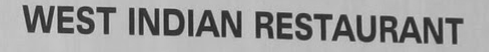

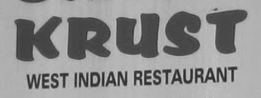

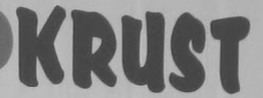

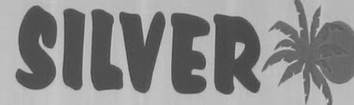

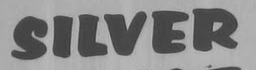

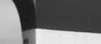

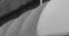

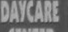

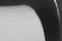

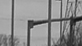

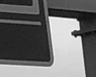

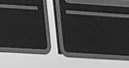

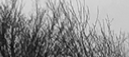

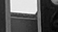

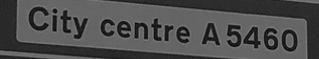

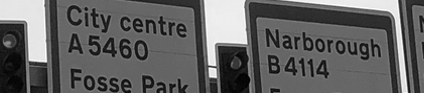

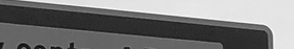

In [278]:
#tlist = [2, 6, 10, 12, 14, 17, 26, 32, 33, 37]
tlist = [6, 10, 12, 32, 37]

for x in tlist:
    with Image.open(f"testimgs\\t{x}.png") as f:
        iar = np.array(f)
    im = Image.fromarray(iar)
    test = get_text(iar, (64, 64), 0.95)
    """ iar = np.rot90(iar, 2)
    test = get_text(iar, (64, 64), 0.5) """
    if test:
        for y in test.values():
            display(Image.fromarray(y))
        


In [ ]:
tlist = [6, 10, 12, 17, 26, 32, 37]
for x in tlist:
    with Image.open(f"testimgs\\t{x}.png") as f:
        iar = np.array(f)
    im = Image.fromarray(iar)
    display(im)

    texts = get_text(iar, (64, 64), 0.5)
    for x in texts:
        display(Image.fromarray(x))